# Porting an analysis from local to distributed

Now comes the opportunity to put in practice what we have just learned!

# Guided exercise

Recreate the boxplot we did in the pandas section, in Spark!

Since matplotlib boxplot needs all the data and that would be unfeasible with Big Data, we will calculate the quartiles ourselves.

Once the analysis is ported, we will be able to run it on the whole historical series! You can find it at https://transtats.bts.gov (On time performance reporting carrier).

##  Workflow

The basic idea is the same that we applied in the Amadeus Challenge:

* Build prototype with small data: in this section, we will be using `06-intro_to_pandas_practical.ipynb` as our already made prototype

* Modify your prototype so that it works with Big Data: In this case, it means porting it to Spark

* Test your "Big Data" prototype with small data: We will first test it with a sample locally, then upload it to a cluster and test it with Big Data.

    * You can run your analyses building your own cluster and storage bucket in Google Cloud Storage. More in notebook #4!

* Run your prototype with Big Data.

    


## Modify the prototype so that it works with Big Data

In [1]:
folder = '/home/eduardo/Data/us_dot/'
filename = 'On_Time_On_Time_Performance_2015_8.zip'
!unzip -o {folder+filename}

Archive:  /home/eduardo/Data/us_dot/On_Time_On_Time_Performance_2015_8.zip
  inflating: On_Time_On_Time_Performance_2015_8.csv  
  inflating: readme.html             


In [2]:
!ls -lrth

total 305M
-rw-r--r-- 1 eduardo eduardo  12K oct  5  2015 readme.html
-rw-r--r-- 1 eduardo eduardo 220M oct  5  2015 On_Time_On_Time_Performance_2015_8.csv
-rw-r--r-- 1 eduardo eduardo  79M may 10 16:55 coupon150720.csv
-rw-rw-r-- 1 eduardo eduardo 5,1M may 10 16:56 shakespeare.txt
-rw-r--r-- 1 eduardo eduardo  739 may 12 16:48 derby.log
-rw-r--r-- 1 eduardo eduardo  96K may 12 16:48 01-first_steps_with_distributed_systems-MapReduce.empty.ipynb
drwxr-xr-x 4 eduardo eduardo 4,0K may 12 16:48 metastore_db
-rw-r--r-- 1 eduardo eduardo  70K may 17 12:56 02-SparkSQL-DataFrames.empty.ipynb
-rw-r--r-- 1 eduardo eduardo 794K may 17 16:50 06-intro_to_pandas_practical.html
-rw-r--r-- 1 eduardo eduardo  21K may 17 16:50 04-working_on_cluster.ipynb
drwxr-xr-x 2 eduardo eduardo 4,0K may 17 17:10 Class_Notebooks
-rw-r--r-- 1 eduardo eduardo  79K may 17 20:26 03-porting-to-spark.empty.ipynb


In [3]:
!head -2 On_Time_On_Time_Performance_2015_8.csv

"Year","Quarter","Month","DayofMonth","DayOfWeek","FlightDate","UniqueCarrier","AirlineID","Carrier","TailNum","FlightNum","OriginAirportID","OriginAirportSeqID","OriginCityMarketID","Origin","OriginCityName","OriginState","OriginStateFips","OriginStateName","OriginWac","DestAirportID","DestAirportSeqID","DestCityMarketID","Dest","DestCityName","DestState","DestStateFips","DestStateName","DestWac","CRSDepTime","DepTime","DepDelay","DepDelayMinutes","DepDel15","DepartureDelayGroups","DepTimeBlk","TaxiOut","WheelsOff","WheelsOn","TaxiIn","CRSArrTime","ArrTime","ArrDelay","ArrDelayMinutes","ArrDel15","ArrivalDelayGroups","ArrTimeBlk","Cancelled","CancellationCode","Diverted","CRSElapsedTime","ActualElapsedTime","AirTime","Flights","Distance","DistanceGroup","CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay","FirstDepTime","TotalAddGTime","LongestAddGTime","DivAirportLandings","DivReachedDest","DivActualElapsedTime","DivArrDelay","DivDistance","Div1Airport","Div1A

## Read csv

We'll use the `SparkSession.read.csv` method.

In [4]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
# Create a Session
spark = SparkSession.builder.getOrCreate()
# How is my session?
spark

In [5]:
# inferSchema intenta inferir el Schema en función de los datos
df = spark.read.csv('On_Time_On_Time_Performance_2015_8.csv',header=True, inferSchema=True)

In [6]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: timestamp (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- AirlineID: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateFips: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DestAirportSeqID: integer (nullable = true)
 |-- DestCityMarketID: integer (nu

## Select relevant columns

Literally the same syntax as Pandas!

In [7]:
df = df.select(['FlightDate',
                'DayOfWeek',
                'Carrier',
                'FlightNum',
                'Origin',
                'OriginCityName',
                'OriginStateName',
                'Dest',
                'DestCityName',
                'DepTime',
                'DepDelay',
                'AirTime',
                'Distance'])
df

DataFrame[FlightDate: timestamp, DayOfWeek: int, Carrier: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DepTime: int, DepDelay: double, AirTime: double, Distance: double]

In [8]:
df.show()

+-------------------+---------+-------+---------+------+--------------+---------------+----+---------------+-------+--------+-------+--------+
|         FlightDate|DayOfWeek|Carrier|FlightNum|Origin|OriginCityName|OriginStateName|Dest|   DestCityName|DepTime|DepDelay|AirTime|Distance|
+-------------------+---------+-------+---------+------+--------------+---------------+----+---------------+-------+--------+-------+--------+
|2015-08-02 00:00:00|        7|     AA|        1|   JFK|  New York, NY|       New York| LAX|Los Angeles, CA|    854|    -6.0|  313.0|  2475.0|
|2015-08-03 00:00:00|        1|     AA|        1|   JFK|  New York, NY|       New York| LAX|Los Angeles, CA|    858|    -2.0|  316.0|  2475.0|
|2015-08-04 00:00:00|        2|     AA|        1|   JFK|  New York, NY|       New York| LAX|Los Angeles, CA|    902|     2.0|  326.0|  2475.0|
|2015-08-05 00:00:00|        3|     AA|        1|   JFK|  New York, NY|       New York| LAX|Los Angeles, CA|    857|    -3.0|  331.0|  2475.0|

In [9]:
df.printSchema()

root
 |-- FlightDate: timestamp (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)



### Extract "Hour" variable

The DepTimes have been inferred to be floats. We need them as ints, representing each o fthe 24 hours in a day.

In [10]:
from pyspark.sql import types

df3 = df.withColumn('Hour',(df['DepTime']/100).cast(types.IntegerType()))
df3.show()

+-------------------+---------+-------+---------+------+--------------+---------------+----+---------------+-------+--------+-------+--------+----+
|         FlightDate|DayOfWeek|Carrier|FlightNum|Origin|OriginCityName|OriginStateName|Dest|   DestCityName|DepTime|DepDelay|AirTime|Distance|Hour|
+-------------------+---------+-------+---------+------+--------------+---------------+----+---------------+-------+--------+-------+--------+----+
|2015-08-02 00:00:00|        7|     AA|        1|   JFK|  New York, NY|       New York| LAX|Los Angeles, CA|    854|    -6.0|  313.0|  2475.0|   8|
|2015-08-03 00:00:00|        1|     AA|        1|   JFK|  New York, NY|       New York| LAX|Los Angeles, CA|    858|    -2.0|  316.0|  2475.0|   8|
|2015-08-04 00:00:00|        2|     AA|        1|   JFK|  New York, NY|       New York| LAX|Los Angeles, CA|    902|     2.0|  326.0|  2475.0|   9|
|2015-08-05 00:00:00|        3|     AA|        1|   JFK|  New York, NY|       New York| LAX|Los Angeles, CA|    

## Generate the relative distributions

In order to be able to handle the data, we need to reduce its dimensionality. Since we want to describe a discrete distribution, we can just count how many values of each level of the 'DepDelay' variable we find for each hour (24 different discrete distributions). We also want the totals in order to do the relative distribution.

### Totals

In [11]:
totals = df3.groupBy('Hour').count().orderBy('Hour')
totals.show()

+----+-----+
|Hour|count|
+----+-----+
|null| 4719|
|   0| 2735|
|   1|  856|
|   2|  212|
|   3|  110|
|   4| 1086|
|   5|17118|
|   6|32634|
|   7|31069|
|   8|31596|
|   9|29865|
|  10|31678|
|  11|29704|
|  12|30579|
|  13|29727|
|  14|27838|
|  15|30730|
|  16|27991|
|  17|31983|
|  18|28566|
+----+-----+
only showing top 20 rows



### Distributions

In [12]:
from pyspark.sql import functions as f
distributions = df3.groupBy(['Hour','DepDelay']).agg(f.count('Hour').alias('count1'))
distributions.orderBy('Hour','DepDelay',ascending=True).show(20)

+----+--------+------+
|Hour|DepDelay|count1|
+----+--------+------+
|null|    null|     0|
|   0|   -20.0|     3|
|   0|   -19.0|     1|
|   0|   -18.0|     3|
|   0|   -17.0|     2|
|   0|   -16.0|     2|
|   0|   -15.0|     3|
|   0|   -14.0|     6|
|   0|   -13.0|     7|
|   0|   -12.0|    13|
|   0|   -11.0|    12|
|   0|   -10.0|    21|
|   0|    -9.0|    31|
|   0|    -8.0|    49|
|   0|    -7.0|    62|
|   0|    -6.0|    72|
|   0|    -5.0|    91|
|   0|    -4.0|   110|
|   0|    -3.0|   123|
|   0|    -2.0|   105|
+----+--------+------+
only showing top 20 rows



In [13]:
!head readme.html

<HTML>
<HEAD>
	<TITLE> readme.html </TITLE>
</HEAD>
<BODY>
	<TABLE><TR><TD COLSPAN=2><H4>BACKGROUND</H4></TD></TR>
	<TR><TD COLSPAN=2>The data contained in the compressed file has been extracted from the 
	On-Time Performance data table of the "On-Time" database from the TranStats data library. 
	The time period is indicated in the name of the compressed file; 
	for example, XXX_XXXXX_2001_1 contains data of the first month of the year 2001. </TD></TR>


Now we join both and calculate what fraction of the total for each hour each level of DepDelay represents.

In [14]:
annotated = distributions.join(totals,on='Hour')
annotated.show()

+----+--------+------+-----+
|Hour|DepDelay|count1|count|
+----+--------+------+-----+
|  13|    19.0|   170|29727|
|  16|    76.0|    30|27991|
|  17|     8.0|   453|31983|
|  17|    72.0|    29|31983|
|  15|   644.0|     1|30730|
|  18|   -11.0|   255|28566|
|  16|    84.0|    28|27991|
|  22|     9.0|   156|12594|
|   4|    -8.0|    92| 1086|
|  22|    73.0|    19|12594|
|   9|   170.0|     3|29865|
|  17|    86.0|    28|31983|
|  23|   129.0|     5| 5781|
|   7|    91.0|     8|31069|
|  21|   -21.0|     3|18255|
|  23|   108.0|    10| 5781|
|  13|   -18.0|    11|29727|
|   7|    52.0|    12|31069|
|  10|    70.0|    16|31678|
|  22|   165.0|    11|12594|
+----+--------+------+-----+
only showing top 20 rows



### Intermission: OTP15

On Time Performance 15 is the standard Key Performance Indicator for airline punctuality. It reflects the proportion of departures that actually took place within 15 minutes of their estimated time of departure.

Let's have a quick look at how it behaves through the day.

In [15]:
frequencies = annotated.withColumn('relative', annotated['count1']/annotated['count'])
frequencies.show()

+----+--------+------+-----+--------------------+
|Hour|DepDelay|count1|count|            relative|
+----+--------+------+-----+--------------------+
|  13|    19.0|   170|29727|0.005718706899451677|
|  16|    76.0|    30|27991|0.001071773069915...|
|  17|     8.0|   453|31983| 0.01416377450520589|
|  17|    72.0|    29|31983|9.067317012162712E-4|
|  15|   644.0|     1|30730|3.254149040026033E-5|
|  18|   -11.0|   255|28566|0.008926696072253729|
|  16|    84.0|    28|27991|0.001000321531920...|
|  22|     9.0|   156|12594|0.012386850881372083|
|   4|    -8.0|    92| 1086|  0.0847145488029466|
|  22|    73.0|    19|12594|0.001508654915038...|
|   9|   170.0|     3|29865|1.004520341536916...|
|  17|    86.0|    28|31983|8.754650908295032E-4|
|  23|   129.0|     5| 5781|8.649022660439371E-4|
|   7|    91.0|     8|31069|2.574913901316425E-4|
|  21|   -21.0|     3|18255|1.643385373870172...|
|  23|   108.0|    10| 5781|0.001729804532087...|
|  13|   -18.0|    11|29727|3.700339758468732E-4|


In [16]:
# Freqcuencia (relative) de vuelos sin retraso por cada hora
frequencies.filter(f.col('DepDelay') == 0).orderBy(frequencies['Hour']).show(30)

+----+--------+------+-----+--------------------+
|Hour|DepDelay|count1|count|            relative|
+----+--------+------+-----+--------------------+
|   0|     0.0|    94| 2735| 0.03436928702010969|
|   1|     0.0|    13|  856|0.015186915887850467|
|   2|     0.0|     6|  212| 0.02830188679245283|
|   3|     0.0|     8|  110| 0.07272727272727272|
|   4|     0.0|     5| 1086|0.004604051565377533|
|   5|     0.0|   760|17118| 0.04439771001285197|
|   6|     0.0|  2238|32634| 0.06857878286449715|
|   7|     0.0|  2184|31069| 0.07029514950593839|
|   8|     0.0|  2138|31596| 0.06766679326497024|
|   9|     0.0|  1949|29865| 0.06526033818851498|
|  10|     0.0|  2041|31678| 0.06442957257402614|
|  11|     0.0|  1828|29704|0.061540533261513604|
|  12|     0.0|  1930|30579| 0.06311520978449263|
|  13|     0.0|  1997|29727| 0.06717798634238234|
|  14|     0.0|  1656|27838| 0.05948703211437603|
|  15|     0.0|  1868|30730|  0.0607875040676863|
|  16|     0.0|  1644|27991| 0.05873316423136008|


In [17]:
frequencies.withColumn('relative_precentage',(f.round(frequencies['relative'],3))).show()

+----+--------+------+-----+--------------------+-------------------+
|Hour|DepDelay|count1|count|            relative|relative_precentage|
+----+--------+------+-----+--------------------+-------------------+
|  13|    19.0|   170|29727|0.005718706899451677|              0.006|
|  16|    76.0|    30|27991|0.001071773069915...|              0.001|
|  17|     8.0|   453|31983| 0.01416377450520589|              0.014|
|  17|    72.0|    29|31983|9.067317012162712E-4|              0.001|
|  15|   644.0|     1|30730|3.254149040026033E-5|                0.0|
|  18|   -11.0|   255|28566|0.008926696072253729|              0.009|
|  16|    84.0|    28|27991|0.001000321531920...|              0.001|
|  22|     9.0|   156|12594|0.012386850881372083|              0.012|
|   4|    -8.0|    92| 1086|  0.0847145488029466|              0.085|
|  22|    73.0|    19|12594|0.001508654915038...|              0.002|
|   9|   170.0|     3|29865|1.004520341536916...|                0.0|
|  17|    86.0|    2

### Generate distributions

We have to group on the hour. Each group will be a bunch of delays and the corresponding frequencies.

In [18]:
groups = frequencies.groupBy(frequencies['Hour'])
groups

These groups are definitely manageable: the number of levels will be on the order of a few hundreds to a couple thousands. We can combine them into lists straight away.

In [19]:
help(f.collect_list)

Help on function collect_list in module pyspark.sql.functions:

collect_list(col)
    Aggregate function: returns a list of objects with duplicates.
    
    .. note:: The function is non-deterministic because the order of collected results depends
        on order of rows which may be non-deterministic after a shuffle.
    
    >>> df2 = spark.createDataFrame([(2,), (5,), (5,)], ('age',))
    >>> df2.agg(collect_list('age')).collect()
    [Row(collect_list(age)=[2, 5, 5])]
    
    .. versionadded:: 1.6



In [20]:
groups = frequencies.groupBy(frequencies['Hour']).agg(f.collect_list('DepDelay').alias('delays'),
                                                      f.collect_list('relative').alias('relatives'))
groups.printSchema()

root
 |-- Hour: integer (nullable = true)
 |-- delays: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relatives: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [21]:
# En una misma entrada estamos recogiendo todos los valores agrupados en una lista
# Para cada hora guardamos el delay y el porcentaje en una lista con F.COLLECT_LIST('COLUMN')
groups.show()

+----+--------------------+--------------------+
|Hour|              delays|           relatives|
+----+--------------------+--------------------+
|  12|[280.0, 167.0, 75...|[3.27021812354884...|
|  22|[9.0, 73.0, 165.0...|[0.01238685088137...|
|   1|[176.0, 223.0, 30...|[0.00116822429906...|
|  13|[19.0, -18.0, 211...|[0.00571870689945...|
|  16|[76.0, 84.0, 289....|[0.00107177306991...|
|   6|[89.0, 648.0, 62....|[3.06428877857449...|
|   3|[-16.0, 108.0, 76...|[0.00909090909090...|
|  20|[173.0, 82.0, 218...|[3.76380060220809...|
|   5|[42.0, -19.0, -18...|[5.84180394905946...|
|  19|[131.0, 140.0, 28...|[6.86600981839404...|
|  15|[644.0, 238.0, 47...|[3.25414904002603...|
|  17|[8.0, 72.0, 86.0,...|[0.01416377450520...|
|   9|[170.0, 67.0, 60....|[1.00452034153691...|
|   4|[-8.0, 3.0, -4.0,...|[0.08471454880294...|
|   8|[-18.0, 121.0, 15...|[1.89897455374097...|
|  23|[129.0, 108.0, 12...|[8.64902266043937...|
|   7|[91.0, 52.0, 51.0...|[2.57491390131642...|
|  10|[70.0, 261.0, 

In [22]:
# How to unstack the Dataframe - flatten, explode
kk = groups.select('Hour',f.explode('delays').alias('delay'))
kk.show()

+----+-----+
|Hour|delay|
+----+-----+
|  12|280.0|
|  12|167.0|
|  12| 75.0|
|  12|-20.0|
|  12|-14.0|
|  12|186.0|
|  12| 31.0|
|  12|  1.0|
|  12|  4.0|
|  12|150.0|
|  12|262.0|
|  12|345.0|
|  12| 28.0|
|  12| 76.0|
|  12| 58.0|
|  12|139.0|
|  12|156.0|
|  12| -8.0|
|  12| 83.0|
|  12|371.0|
+----+-----+
only showing top 20 rows



Now it's be easy to use a UDF to merge the two lists and sort them.

In [23]:
def zipsort(a,b):
    return sorted(zip(a,b))

udf_zipsort = f.udf(zipsort, types.ArrayType(types.ArrayType(types.FloatType())))

In [24]:
dist = groups.withColumn('distributions',udf_zipsort('delays','relatives'))
dist.show()

+----+--------------------+--------------------+--------------------+
|Hour|              delays|           relatives|       distributions|
+----+--------------------+--------------------+--------------------+
|  12|[280.0, 167.0, 75...|[3.27021812354884...|[[-30.0, 3.270218...|
|  22|[9.0, 73.0, 165.0...|[0.01238685088137...|[[-24.0, 7.940289...|
|   1|[176.0, 223.0, 30...|[0.00116822429906...|[[-22.0, 0.001168...|
|  13|[19.0, -18.0, 211...|[0.00571870689945...|[[-36.0, 3.363945...|
|  16|[76.0, 84.0, 289....|[0.00107177306991...|[[-29.0, 3.572577...|
|   6|[89.0, 648.0, 62....|[3.06428877857449...|[[-23.0, 3.064289...|
|   3|[-16.0, 108.0, 76...|[0.00909090909090...|[[-20.0, 0.009090...|
|  20|[173.0, 82.0, 218...|[3.76380060220809...|[[-39.0, 4.182000...|
|   5|[42.0, -19.0, -18...|[5.84180394905946...|[[-30.0, 5.841803...|
|  19|[131.0, 140.0, 28...|[6.86600981839404...|[[-27.0, 3.433005...|
|  15|[644.0, 238.0, 47...|[3.25414904002603...|[[-26.0, 3.254149...|
|  17|[8.0, 72.0, 86

In [25]:
dist.printSchema()

root
 |-- Hour: integer (nullable = true)
 |-- delays: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relatives: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- distributions: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: float (containsNull = true)



Careful! If we keep that string return type, it might be problematic later.

In [26]:
dist.first()['distributions'][:10]

[[-30.0, 3.2702180760679767e-05],
 [-24.0, 9.81065459200181e-05],
 [-23.0, 9.81065459200181e-05],
 [-22.0, 6.540436152135953e-05],
 [-21.0, 0.00013080872304271907],
 [-20.0, 0.00022891526168677956],
 [-19.0, 0.00016351090744137764],
 [-18.0, 0.00029431964503601193],
 [-17.0, 0.0006540436297655106],
 [-16.0, 0.0008502567070536315]]

In [27]:
type(dist.first()['distributions'][:100])

list

In [28]:
dist.cache()

DataFrame[Hour: int, delays: array<double>, relatives: array<double>, distributions: array<array<float>>]

In [29]:
first_row = dist.first()

In [30]:
histogram = first_row['distributions']
histogram

[[-30.0, 3.2702180760679767e-05],
 [-24.0, 9.81065459200181e-05],
 [-23.0, 9.81065459200181e-05],
 [-22.0, 6.540436152135953e-05],
 [-21.0, 0.00013080872304271907],
 [-20.0, 0.00022891526168677956],
 [-19.0, 0.00016351090744137764],
 [-18.0, 0.00029431964503601193],
 [-17.0, 0.0006540436297655106],
 [-16.0, 0.0008502567070536315],
 [-15.0, 0.0015370025066658854],
 [-14.0, 0.0024526636116206646],
 [-13.0, 0.003858857322484255],
 [-12.0, 0.005624775309115648],
 [-11.0, 0.0076196081936359406],
 [-10.0, 0.015010301023721695],
 [-9.0, 0.01942509599030018],
 [-8.0, 0.026488766074180603],
 [-7.0, 0.03950423374772072],
 [-6.0, 0.05686909332871437],
 [-5.0, 0.07498610019683838],
 [-4.0, 0.07688283175230026],
 [-3.0, 0.08489486575126648],
 [-2.0, 0.0813303217291832],
 [-1.0, 0.07060401141643524],
 [0.0, 0.0631152093410492],
 [1.0, 0.03132868930697441],
 [2.0, 0.023610975593328476],
 [3.0, 0.020013734698295593],
 [4.0, 0.017005134373903275],
 [5.0, 0.01690702699124813],
 [6.0, 0.01553353574126958

In [31]:
import matplotlib.pyplot as plt

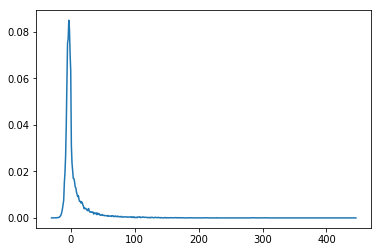

In [32]:
plt.plot(*zip(*histogram));

### Calculating the quartiles

We are finally ready to calculate the quartiles! We will use a UDF.

The input to our custom function will be one of the distributions coded like we did: as a list of tuples `(value, relative_frequency)`. The quartiles are defined as the values at which we cross the 0.0, .25, .5, .75 and 1.00 relative frequencies. Since the distributions are ordered, we can just iterate over one while keeping track of what portion of the total distribution we have seen, and annotate where we cross the thresholds.

In [33]:
def quartiles(histogram):
    area=0
    result=[]
    for value, percentage in histogram:
        if area == 0:
            result.append(value)
        elif area <= 0.25 and area+percentage > 0.25:
            result.append(value)
        elif area <= 0.5 and area+percentage > 0.5:
            result.append(value)
        elif area <= 0.75 and area+percentage > 0.75:
            result.append(value)
        area += percentage
    result.append(value)
    return result

quartiles(histogram)    

[-30.0, -5.0, -1.0, 6.0, 446.0]

In [35]:
dist.show(2)

+----+--------------------+--------------------+--------------------+
|Hour|              delays|           relatives|       distributions|
+----+--------------------+--------------------+--------------------+
|  12|[280.0, 167.0, 75...|[3.27021812354884...|[[-30.0, 3.270218...|
|  22|[9.0, 73.0, 165.0...|[0.01238685088137...|[[-24.0, 7.940289...|
+----+--------------------+--------------------+--------------------+
only showing top 2 rows



### Plotting

We got it! Let's move this over to Pandas for convenient handling

In [42]:
udf_quartiles = f.udf(quartiles, types.ArrayType(types.FloatType()))

result = dist.withColumn('quartiles', udf_quartiles(dist['distributions']))
result = result.select('Hour','quartiles')
result.show(5)

+----+--------------------+
|Hour|           quartiles|
+----+--------------------+
|  12|[-30.0, -5.0, -1....|
|  22|[-24.0, -3.0, 6.0...|
|   1|[-22.0, -1.0, 19....|
|  13|[-36.0, -4.0, -1....|
|  16|[-29.0, -4.0, 0.0...|
+----+--------------------+
only showing top 5 rows



In [43]:
resultPandas = result.toPandas()

In [44]:
resultPandas.head()

,Hour,quartiles
0,12,"[-30.0, -5.0, -1.0, 6.0, 446.0]"
1,22,"[-24.0, -3.0, 6.0, 39.0, 907.0]"
2,1,"[-22.0, -1.0, 19.0, 92.0, 486.0]"
3,13,"[-36.0, -4.0, -1.0, 7.0, 1171.0]"
4,16,"[-29.0, -4.0, 0.0, 12.0, 687.0]"


And we are ready to plot!

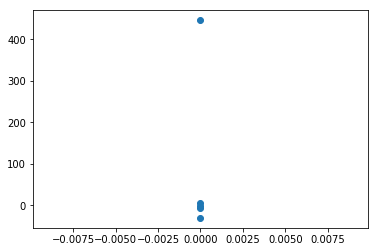

In [49]:
plt.scatter([0]*5,resultPandas['quartiles'][0])

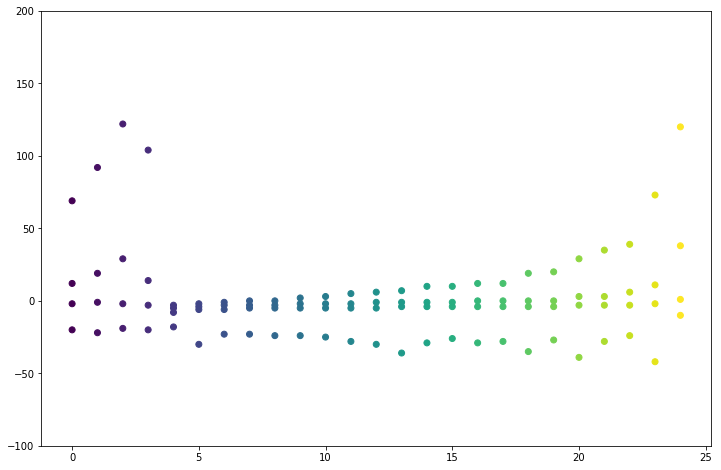

In [51]:
xs = []
ys = []

for ix,hour in enumerate(resultPandas['Hour']):
    xs.extend([hour]*5)
    ys.extend(resultPandas.loc[ix]['quartiles'])
    
plt.scatter(xs,ys,c=xs)
plt.gca().set_ylim(-100,200)
plt.gcf().set_size_inches(12,8)

## Test your "Big Data" prototype with small data

### Summary

This is the whole process, collected in one place as is:

In [58]:
########################################################### LIBRARIES ###########################################################
from __future__ import print_function
from pyspark.sql import SparkSession, types
from pyspark.sql import functions as f
import sys

########################################################### FUNCTIONS ###########################################################
def zipsort(a,b):
    return sorted(zip(a,b))

def quartiles(histogram):
    area=0
    result=[]
    for value, percentage in histogram:
        if area == 0:
            result.append(value)
        elif area <= 0.25 and area+percentage > 0.25:
            result.append(value)
        elif area <= 0.5 and area+percentage > 0.5:
            result.append(value)
        elif area <= 0.75 and area+percentage > 0.75:
            result.append(value)
        area += percentage
    result.append(value)
    return result

############################################################## UDFs ##############################################################
udf_zipsort = f.udf(zipsort, types.ArrayType(types.ArrayType(types.FloatType())))
udf_quartiles = f.udf(quartiles, types.ArrayType(types.FloatType()))


####################################################### START THE FLOW ##########################################################
if __name__ == "__main__": # to convert this in an app. Spark summit needs it

    file = sys.argv[1]
    out = sys.argv[2]

    # Create the SparkSession
    spark = SparkSession.builder.getOrCreate()

    # Read the file and select desired fields
    df = spark.read.csv(file, header=True, inferSchema=True)\
              .select(['FlightDate',
                       'DayOfWeek',
                       'Carrier',
                       'FlightNum',
                       'Origin',
                       'OriginCityName',
                       'OriginStateName',
                       'Dest',
                       'DestCityName',
                       'DepTime',
                       'DepDelay',
                       'AirTime',
                       'Distance'])

    # Obtaining counts on hour and hour-delay in order to find relative weight
    df2 =  df.withColumn('Hour',(df['DepTime']/100).cast(types.IntegerType()))
    totals = df2.groupBy('Hour').agg(f.count('Hour').alias('countTotal'))
    distributions = df2.groupBy('Hour','DepDelay').agg(f.count('Hour').alias('countDelay'))
    annotated = distributions.join(totals, on='Hour')

    # Calculate realtive weight
    frequencies = annotated.withColumn('relative', annotated['countDelay']/annotated['countTotal'])

    # Collect all DepDelays and relative weights in two new fields (as List/Array)
    groups = frequencies.groupBy(frequencies['Hour']).agg(f.collect_list('DepDelay').alias('delays'),
                                                          f.collect_list('relative').alias('relatives'))

    # UDF Create Zip of delays with relatives in order to create histograms per hour
    histograms = groups.withColumn('distributions',udf_zipsort('delays','relatives'))

    # UDF Create quartiles
    result = histograms.withColumn('quartiles', udf_quartiles(histograms['distributions']))

    # # Select Hour and quartiles
    # result = result.select('Hour','quartiles')

    result.coalesce(1).write.json(out)

### Pyspark job

In order to run the process in a cluster, we need to transform it into a pyspark job file. 

We need to tidy up the function definitions, add the relevant imports, and modify the input and output to use command-line arguments.

We will put the result in a file called mysparkjob.py:

```python

from __future__ import print_function
from pyspark.sql import SparkSession
import sys
from pyspark.sql import types, functions


def zip_sort(delays, fractions):
    return sorted(zip(delays, fractions))


def quartiles(distribution):
    cumulative = 0.0
    result = []
    for delay, percentage in distribution:
        next_cumulative = cumulative + percentage
        if cumulative == 0.0:
            # minimum
            result.append(delay) 
        if cumulative < .25 and next_cumulative > .25:
            # 1st quartile
            result.append(delay) 
        if cumulative < .5 and next_cumulative > .5:
            # median
            result.append(delay) 
        if cumulative < .75 and next_cumulative > .75:
            # 3rd quartile
            result.append(delay) 
            
        cumulative = next_cumulative
    
    # maximum
    result.append(delay) 
    
    return result


if __name__ == "__main__": # Para que sea un programa
    
    file = sys.argv[1]
    out = sys.argv[2]
    
    spark = SparkSession.builder.getOrCreate()
    df = spark.read.csv(file, header=True, inferSchema=True)
    timesdelays = df[['DepTime', 'DepDelay']]

    hoursdelays = timesdelays.select((timesdelays['DepTime'] / 100).cast(types.IntegerType()).alias("Hour"),
                                      'DepDelay')
    totals_per_hour = hoursdelays.groupBy('Hour').count()
    totals_per_hourdelay = hoursdelays.groupBy(['Hour', 'DepDelay']).count()
    frequencies = totals_per_hourdelay.join(totals_per_hour, on="Hour")\
                                      .select(totals_per_hourdelay['Hour'],
                                              'DepDelay',
                                              totals_per_hourdelay['count'].alias('count'),
                                              totals_per_hour['count'].alias('total'),
                                              (totals_per_hourdelay['count'] / totals_per_hour['count']).alias('fraction'))

    groups = frequencies.groupBy('Hour')
    distributions = groups.agg(functions.collect_list('DepDelay').alias('delays'), 
                               functions.collect_list('fraction').alias('fractions'),
                               functions.count('fraction').alias('len')).cache()

    zip_sort_udf = functions.udf(zip_sort, 
	                     returnType=types.ArrayType(
	                                  types.ArrayType(
	                                    types.FloatType()
	                                  )
	                                )
	                    )
    merged_distributions = distributions.select('Hour',
                                     zip_sort_udf(distributions['delays'], distributions['fractions']).alias('density_function'))


    quartiles_udf = functions.udf(quartiles, types.ArrayType(types.FloatType()))

    stats = merged_distributions.withColumn('quartiles', 
                                            quartiles_udf('density_function').cast(types.StringType()))

    stats.write.json(out)

```

### Running with spark-submit

If the following works, we are ready to test it in the cluster!

```python
unset PYSPARK_DRIVER_PYTHON # para que una máquina local pueda correr como un cluster
spark-submit mysparkjob.py On_Time_On_Time_Performance_2015_8.csv out.csv
```

## Prepare our script to run on our google cloud cluster

In [ ]:
########################################################### LIBRARIES ###########################################################
from __future__ import print_function
from pyspark.sql import SparkSession, types
from pyspark.sql import functions as f
import sys

########################################################### FUNCTIONS ###########################################################
def zipsort(a,b):
    return sorted(zip(a,b))

def quartiles(histogram):
    area=0
    result=[]
    for value, percentage in histogram:
        if area == 0:
            result.append(value)
        elif area <= 0.25 and area+percentage > 0.25:
            result.append(value)
        elif area <= 0.5 and area+percentage > 0.5:
            result.append(value)
        elif area <= 0.75 and area+percentage > 0.75:
            result.append(value)
        area += percentage
    result.append(value)
    return result

############################################################## UDFs ##############################################################
udf_zipsort = f.udf(zipsort, types.ArrayType(types.ArrayType(types.FloatType())))
udf_quartiles = f.udf(quartiles, types.ArrayType(types.FloatType()))


####################################################### START THE FLOW ##########################################################

# Take input and output paths
#if __name__ == "__main__": # to convert this in an app. Spark summit needs it

file = sys.argv[1]
out = sys.argv[2]

# Create the SparkSession
spark = SparkSession.builder.getOrCreate()

# Read the file and select desired fields
df = spark.read.csv(file, header=True, inferSchema=True)\
          .select(['FlightDate',
                   'DayOfWeek',
                   'Carrier',
                   'FlightNum',
                   'Origin',
                   'OriginCityName',
                   'OriginStateName',
                   'Dest',
                   'DestCityName',
                   'DepTime',
                   'DepDelay',
                   'AirTime',
                   'Distance'])

# Obtaining counts on hour and hour-delay in order to find relative weight
df2 =  df.withColumn('Hour',(df['DepTime']/100).cast(types.IntegerType()))
totals = df2.groupBy('Hour').agg(f.count('Hour').alias('countTotal'))
distributions = df2.groupBy('Hour','DepDelay').agg(f.count('Hour').alias('countDelay'))
annotated = distributions.join(totals, on='Hour')

# Calculate realtive weight
frequencies = annotated.withColumn('relative', annotated['countDelay']/annotated['countTotal'])

# Collect all DepDelays and relative weights in two new fields (as List/Array)
groups = frequencies.groupBy(frequencies['Hour']).agg(f.collect_list('DepDelay').alias('delays'),
                                                      f.collect_list('relative').alias('relatives'))

# UDF Create Zip of delays with relatives in order to create histograms per hour
histograms = groups.withColumn('distributions',udf_zipsort('delays','relatives'))

# UDF Create quartiles
result = histograms.withColumn('quartiles', udf_quartiles(histograms['distributions']).alias('quartiles'))

# # Select Hour and quartiles
# result = result.select('Hour','quartiles')

result.write.json(out)

1. Creamos el script. En este caso lo he llamado excited2.py
2. gsutil cp excited2.py gs://kschool-edition14/EdML/  # Copiando script en un bucket
3. gcloud dataproc jobs submit pyspark --cluster cluster-kschool-12 --region europe-west1 gs://kschool-edition14/EdML/excited2.py -- gs://kschool-edition14/On_Time_On_Time_Performance_2015_8.csv gs://kschool-edition14/EdML/out.csv # ejecutando cluster
4. gsutil ls gs://kschool-edition14/EdML/ # Para ver que hay dentro del bucket y saber que se ha creado y ejecutado bien el script y sus salidas
5. gsutil cp -r gs://kschool-edition14/EdML/out.csv ~/Repos/ # Mandar archivo de salida a nuestro pc 